In [127]:
from bs4 import BeautifulSoup
import pandas as pd
import os
import re
import requests
import logging
import threading
import math
import seaborn as sns
from matplotlib import pyplot as plt

<h1 style="color:yellow;"> Scraping our data</h1>
<h3> First thing we need to do to start the project would be to gather our data</h3>
<p> We would like to find a reliable website of a very known fighting organization , this way we can trust the data since it is an official fighting organization </p>
<p>We are going to scrape ESPN official website for getting our data </p>
<a href="http://www.espn.com/mma/fighters">  Link to ESPN's website where we can observe the fighter list </a>

In [128]:
user_agent = {'User-agent': 'Mozilla/5.0'}

<h3> First we would like to have a list with links for all pages of of the fither list </h3>
<h3> first page will contain fithers with name started with letter A</h3>
<h3> first page will contain fithers with name started with letter Z</h3>

In [129]:
url1="http://www.espn.com/mma/fighters"
response1 = requests.get(url1,headers=user_agent)
pagesAToZ=[]
# we would like to add the first page (the page that contains fighters with letter A)
pagesAToZ.append(url1)
soup1 = BeautifulSoup(response1.content, "html.parser")
div_t=soup1.find("div",attrs={"class":"mod-content"})
hred_t=div_t.findAll("a")
for t in hred_t :
    pagesAToZ.append(url1+t['href'])


<h3>Let's print the urls so we can make sure everything looks fine </h3>

In [130]:
print(pagesAToZ)

['http://www.espn.com/mma/fighters', 'http://www.espn.com/mma/fighters?search=b', 'http://www.espn.com/mma/fighters?search=c', 'http://www.espn.com/mma/fighters?search=d', 'http://www.espn.com/mma/fighters?search=e', 'http://www.espn.com/mma/fighters?search=f', 'http://www.espn.com/mma/fighters?search=g', 'http://www.espn.com/mma/fighters?search=h', 'http://www.espn.com/mma/fighters?search=i', 'http://www.espn.com/mma/fighters?search=j', 'http://www.espn.com/mma/fighters?search=k', 'http://www.espn.com/mma/fighters?search=l', 'http://www.espn.com/mma/fighters?search=m', 'http://www.espn.com/mma/fighters?search=n', 'http://www.espn.com/mma/fighters?search=o', 'http://www.espn.com/mma/fighters?search=p', 'http://www.espn.com/mma/fighters?search=q', 'http://www.espn.com/mma/fighters?search=r', 'http://www.espn.com/mma/fighters?search=s', 'http://www.espn.com/mma/fighters?search=t', 'http://www.espn.com/mma/fighters?search=u', 'http://www.espn.com/mma/fighters?search=v', 'http://www.espn.c

<h3> Another function we would like to writw is a functions that scrapes the most inner page that contain previews fights stats , we would like to get a path as an argument</h3>

In [131]:
def scrapeinnerPageForFightStats(path):
    
    wins =""
    loses =""
    decision = ""
    winByKo = ""
    loseByKo= ""
    winbySubmission=""
    loseBySubmission=""
    page_link='http://www.espn.com'+path
   #  print("pagelink is" , page_link )
    response= requests.get(page_link)
    soup = BeautifulSoup(response.content)
    regex_winsLosesDecision = "W-L-D(\d)-(\d)-(\d)"
    regex_ko="\(T\)KO(\d)-(\d)"
    regex_sub="SUB(\d)-(\d)"
    ul_t = soup.find("ul", attrs={"class":"StatBlock__Content flex list ph4 pv3 justify-between"}) 
    if(ul_t==None):
       print("No unordered list atrr")

    if( (not hasattr(ul_t,'findAll')) ):
      return wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission

   
    if( not ul_t.findAll("li") ):
      return wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission
        
    li_list=ul_t.findAll("li")
    for li in li_list:
       text=li.text
    #    print(text)
       winLoseDecStats_regex_res=re.search(regex_winsLosesDecision , text)
       koStats_regex_res=re.search(regex_ko , text)
       subStats_regex_res=re.search(regex_sub , text)
       if(winLoseDecStats_regex_res):
           wins=winLoseDecStats_regex_res.group(1)
           loses=winLoseDecStats_regex_res.group(2)
           decision=winLoseDecStats_regex_res.group(3)
        #    print(winLoseDecStats_regex_res)
       elif(koStats_regex_res):
           winByKo=koStats_regex_res.group(1)
           loseByKo=koStats_regex_res.group(2)
        #    print(koStats_regex_res)
       elif(subStats_regex_res):
           winbySubmission=subStats_regex_res.group(1)
           loseBySubmission=subStats_regex_res.group(2)
        #    print(subStats_regex_res)
    logging.info(wins,[wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission])
    print(wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission)
    return wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission


<h3> Let's make sure we get the right return params and that the regexes are fine</h3>
<p> we will expect three matches and output params ('0', '1', '0', '0', '0', '0', '1') </p>

In [132]:
# scrapeinnerPageForFightStats('/mma/fighter/_/id/3043549/niina-aaltonen')

<h3> Cool , We have a list of links to each page we want to scrape and the stats from the inner pages! </h3>
<h4>Now we would like to build a function for scraping each page  </h4>

<p>
/The structure of the page containes a long table with two columns . <br>
First Column - Name <br>
Sec Column - Country <br>

the Name is clickable and redirect us to another page with more details of the fighter
 </p>

In [133]:
def getTableRows(page_link):
    response= requests.get(page_link)
    soup = BeautifulSoup(response.content)
    table = soup.find(lambda tag: tag.name=='table') 
    rows = table.findAll(lambda tag: tag.name=='tr')
    # we would like to remove the first two rows bc it doesnt contain any data
    del rows[0]
    del rows[0]
    return rows

In [134]:
def runOnSingleDataRowGetNameCountryBio(row):
    #currently runs only on the first row
        full_name , link_to_bio , country = "" , "" ,""
        cells = row.findAll(lambda tag: tag.name=='td')
        if(cells == None or (not cells)):
            return 
        full_name = cells[0].find("a").text
        full_name=full_name.split(", ")
        first_name=full_name[0]
        last_name=full_name[1]
        link_to_bio = cells[0].find("a")["href"]
        country=cells[1].text
        full_name=first_name+" "+last_name 
        return full_name , link_to_bio ,country



In [135]:
def scrapeTheWholePage(page_url):
    data=[]
    rows=getTableRows(page_url)
    for row in rows:
        full_name  , bio_link , country = runOnSingleDataRowGetNameCountryBio(row)
        wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission =scrapeinnerPageForFightStats(bio_link)
        # print(full_name , bio_link , country)
        # print(wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission)
        listOfParams=[full_name  , country , wins , loses , decision , winByKo , loseByKo, winbySubmission , loseBySubmission ]
        # print(listOfParams)
        print(full_name)
        logging.info(full_name)
        data.append(listOfParams)
        # now we need to return DF with the whole page data
        #next were gonna gather all the dfs together and save it to a file
    #return df
    
    df = pd.DataFrame(data, columns=['Full_Name', 'Country', 'Wins' , 'Loses' ,'Decision' , 'Wins_By_KO' , 'Loses_By_KO', 'Wins_By_Submission' , 'Loses_By_Submission' ])
    return df

    

<h3> test ourselves on the main page </h3>

In [136]:
# scrapeTheWholePage('http://www.espn.com/mma/fighters')

<h3>Now we need to orginize our data in a csv file  , since we have lots of data , we will split it to a few files</h3>

In [137]:
def dataframToCsvFile(df , file_name, path):
    os.makedirs(path, exist_ok=True) 
    df.to_csv(path+file_name , index=False)  

In [138]:
def scrapePageAndSaveToCsv(page_link , page_num):
        df=scrapeTheWholePage(page_link)
        dataframToCsvFile(df,'dataPage'+str(page_num))
        


<h3> We're going to use threads to scrape all pages in pharllel </h3>

In [139]:

def scrapeMultiPagesAnd(pagesToScrap):
    threadList=[]
    for i in range(len(pagesToScrap)):
             threadObj=threading.Thread(target=scrapePageAndSaveToCsv, args=(pagesToScrap[i],i+6,))
             threadObj.start();
             threadList.append(threadObj)
    for t in threadList:
             t.join();

In [140]:
pagesToScrap=pagesAToZ
# scrapeMultiPagesAnd(pagesToScrap)

<h3> Perfect ! now we have all our data scraped and reay for the next step 🥳 🥳 </h3>


<h1 > Next Step <br>
<span style="color:green;"> Cleaning our Data 🧽 🧹<span> </h1>

In [141]:
def load_csv(filename):
    return pd.read_csv(filename)

In [142]:
df=load_csv('./scrapedData/dataPage25.csv')
df.head(10)


,Full_Name,Country,Wins,Loses,Decision,Wins_By_KO,Loses_By_KO,Wins_By_Submission,Loses_By_Submission
0,Zaba Arkadiusz,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Zaba Marcin,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Zabolotny Dmitry,NaN,1.0,3.0,0.0,0.0,2.0,1.0,1.0
3,Zabrocki Michael,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Zac Charlie,NaN,0.0,2.0,0.0,0.0,0.0,0.0,2.0
5,Zachrich Luke,USA,NaN,NaN,NaN,4.0,1.0,7.0,3.0
6,Zaczkiewicz Sylwia,POL,0.0,1.0,0.0,0.0,1.0,0.0,0.0
7,Zadernovsky Igor,POL,0.0,2.0,0.0,0.0,0.0,0.0,2.0
8,Zadruzynski Filip,POL,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9,Zafir Anton,AUS,7.0,3.0,0.0,3.0,3.0,3.0,0.0


In [143]:
def fillNansWihtValues(df , col_names_list , value_to_fill_with):
    df_cpy=df.copy();
    for col_name in col_names_list:
         df_cpy[col_name]=df_cpy[col_name].fillna(value_to_fill_with).copy()
    return df_cpy


In [144]:
def removeColFromDf(df , cols_list_to_remove):
    df_cpy=df.copy()
    return df_cpy.drop(cols_list_to_remove , axis=1)

In [145]:
def addColToDf(df , col_name , col_fixed_value):
    df_cpy=df.copy()
    df_cpy[col_name]=col_fixed_value
    return df_cpy


In [146]:
def remove_rows_with_NA_vals_in_specific_col(df , specific_col ):
    df_cpy=df.copy()
    return df_cpy.dropna(subset=[specific_col])


In [147]:
def remove_duplicates(df, col):
    df_cpy=df.copy()
    df_cpy=df_cpy.drop_duplicates(subset=[col])
    return df_cpy

In [148]:
df.head(5)

,Full_Name,Country,Wins,Loses,Decision,Wins_By_KO,Loses_By_KO,Wins_By_Submission,Loses_By_Submission
0,Zaba Arkadiusz,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Zaba Marcin,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,Zabolotny Dmitry,NaN,1.0,3.0,0.0,0.0,2.0,1.0,1.0
3,Zabrocki Michael,NaN,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Zac Charlie,NaN,0.0,2.0,0.0,0.0,0.0,0.0,2.0


In [149]:
def fillWinsAndLosesCol(df):
    df_cpy=df.copy()
    for index,row in df_cpy.iterrows():
         row['Wins']=row['Wins_By_KO']+row['Wins_By_Submission']
         row['Loses']=row['Loses_By_KO']+row['Loses_By_Submission']
         dec=row['Decision']
         if dec==float('NaN') or math.isnan(dec) or (not dec):
              row['Decision']=0
    return df_cpy


In [150]:
def dataCleanUpFlow(out_folder_loc , list_of_file_names):
    for file in list_of_file_names:
        scrapedData_filename='./scrapedData/'+file+'.csv'

        df=load_csv(scrapedData_filename)
        df=remove_duplicates(df , 'Full_Name')
        df=remove_rows_with_NA_vals_in_specific_col(df , 'Country' )
        df=remove_rows_with_NA_vals_in_specific_col(df , 'Full_Name' )
        df=fillNansWihtValues(df , ['Loses','Wins','Decision' , 'Wins_By_KO' , 'Loses_By_KO' , 'Wins_By_Submission','Loses_By_Submission'] , 0)
        df=fillWinsAndLosesCol(df)
        df=addColToDf(df , 'Champion' , 0)
        dataframToCsvFile(df,file+'.csv' , out_folder_loc)

        
        
        

In [151]:
listOfFiles=['dataPage'+str(i)  for i in range(26)]
path='./cleanedData/'
dataCleanUpFlow(path,listOfFiles)
listOfFiles.insert(0,'ufc_athlets')
listOfFiles.insert(1,'bellator_athlets')



In [152]:
def concat_dataframes(listOfFiles):
    dfList=[]
    for f in listOfFiles:
        df=load_csv('./cleanedData/'+f+'.csv')
        dfList.append(df)
   
    df= pd.concat(dfList)
    dataframToCsvFile(df,'allData.csv','./allDataMerged/')


In [153]:
df_all_tables= concat_dataframes(listOfFiles)


In [154]:
ufc_champs=["Francis Ngannou","Glover Teixeira","Israel Adesanya",
"Kamaru Usman","Charles Oliveira","Alexander Volkanovski","Aljamain Sterling",
"Petr Yan","Deiveson Figueiredo","Amanda Nunes","Julianna Pena","Valentina Shevchenko",
"Rose Namajunas","Randy Couture" , "Antonio Rodrigo Nogueira","Brock Lesnar",
"Frank Mir","Shane Carwin","Junior dos Santos",
"Cain Velasquez","Fabrício Werdum" , "Stipe Miocic",
"Daniel Cormier","Frank Shamrock","Tito Ortiz","Randy Couture","Vitor Belfort",
"Chuck Liddell","Quinton Jackson","Forrest Griffin","Rashad Evans","Lyoto Machida",
"Maurício Rua", "Jon Jones","Dave Menne","Murilo Bustamante","Evan Tanner","Rich Franklin",
"Anderson Silva","Chris Weidman", "Frankie Edgar","Benson Henderson","Anthony Pettis"
,"Luke Rockhold","Michael Bisping","Robert Whittaker","Georges St-Pierre","Robert Whittaker",
"Pat Miletich","Carlos Newton","Matt Hughes","B.J. Penn","Johny Hendricks","Robbie Lawler",
"Tyron Woodley","Rafael dos Anjos","Eddie Alvarez","Conor McGregor","Tony Ferguson",
"Khabib Nurmagomedov","Dustin Poirier","Charles Oliveira","Jose Aldo","Conor McGregor","Max Holloway",
"Alexander Volkanovski","Dominick Cruz","T.J. Dillashaw","Cody Garbrandt","T.J. Dillashaw","Cris Cyborg",
"Ronda Rousey","Holly Holm","Miesha Tate","Ken Shamrock"
]
bellator_champs=["Cole Konrad","Alexander Volkov","Vitaly Minakov","Ryan Bader",
"Valentin Moldavsky","Christian M'Pumbu","Attila Vegh",
"Emanuel Newton","Liam McGeary","Phil Davis",
"Ryan Bader","Vadim Nemkov","Hector Lombard","Alexander Shlemenko","Brandon Halsey",
"Rafael Carvalho","Gegard Mousasi","Rafael Lovato Jr",
"Gegard Mousasi","Lyman Good",
"Ben Askren","Douglas Lima","Andrey Koreshkov",
"Douglas Lima","Rory MacDonald","Yaroslav Amosov","Eddie Alvarez","Michael Chandler",
"Eddie Alvarez","Will Brooks","Brent Primus","Patrício Pitbull","Joe Soto","Joe Warren",
"Pat Curran","Daniel Straus","A.J. McKee","Zach Makovsky","Eduardo Dantas","Joe Warren",
"Marcos Galvão","Darrion Caldwell","Kyoji Horiguchi","Juan Archuleta","Sergio Pettis","Julia Budd"

]

allChamps=ufc_champs+bellator_champs
# checkNameAndChangeChampionVal(df , list_of_champions)

In [155]:
def reverse_word(sentence):
    words=sentence.split()
    reversed_sentence=' '.join(reversed(words))
    return reversed_sentence

In [156]:

def checkNameAndChangeChampionVal(df , list_of_champions):
    # for each row  -> if name in list_of_champions ->isChamp= 1
    # df = df.reset_index()
    champ_set=set(list_of_champions)
    print("Started :",len(champ_set))

    df_cpy=df.copy()
    for index,row in df_cpy.iterrows():
        # print(row["Full_Name"].strip())
        if (row["Full_Name"].strip() in champ_set)  :
            row['Champion']  =1
            champ_set.remove(row["Full_Name"].strip()) 
        elif (reverse_word(row['Full_Name']) in champ_set ) :
            row['Champion']  = 1
            champ_set.remove(reverse_word(row["Full_Name"].strip()))
    print(len(champ_set))
    print(champ_set)

    return df_cpy

<h3> Yay ! We have alll of our data cleaned up , merged and ready for work !
</h3>

<h1> 
Next Step :<span style="color:#FF00FF;">  Visualisation</span>
 </h1>

<h3> first we need to load the merged data frame </h3>


In [158]:
df=load_csv('./allDataMerged/allData.csv')
for  row in df["Country"]:
    row=row.strip()
for  row in df["Full_Name"]:
    row=row.strip()
df=remove_duplicates(df, 'Full_Name')
df=checkNameAndChangeChampionVal(df,ufc_champs)
df=checkNameAndChangeChampionVal(df,bellator_champs)
dataframToCsvFile(df,'ready_for_process_data.csv','./readyForProcess/')

Started : 69
6
{'Fabrício Werdum', 'Antonio Rodrigo Nogueira', 'Julianna Pena', 'T.J. Dillashaw', 'B.J. Penn', 'Junior dos Santos'}
Started : 41
2
{'Marcos Galvão', 'Rafael Lovato Jr'}


<AxesSubplot:xlabel='Wins', ylabel='Density'>

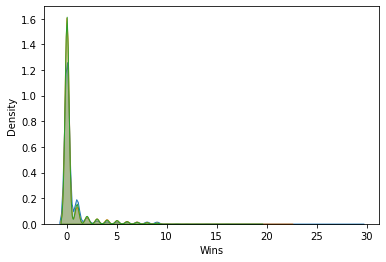

In [117]:

sns.kdeplot(df.Wins, shade=True)
sns.kdeplot(df.Wins_By_KO, shade=True)
sns.kdeplot(df.Wins_By_Submission, shade=True)







<AxesSubplot:xlabel='Loses', ylabel='Density'>

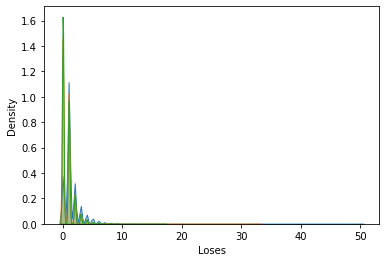

In [118]:
sns.kdeplot(df.Loses, shade=True)
sns.kdeplot(df.Loses_By_KO, shade=True)
sns.kdeplot(df.Loses_By_Submission, shade=True)

In [164]:
df['Country'].unique()
obj={'Belarus':'BEL',' Belarus':'BEL', 'United States':'USA', 'Sweden ':'SWE', 'Haiti ':'HAI', 'Brazil ':'BRA',
       'Russian Federation':'RUS', 'Cameroon ':'CAM', 'Syria ':'SYR', 'Poland ':'POL',
       'Australia ':'AUS', 'Bulgaria ':'BUL', 'Spain ':'ESP', 'Suriname ':'SUR', 'Moldova ':'MDV',
       'France ':'FRA', 'Canada ':'CAN', 'England ':'ENG', 'Ukraine ':'UKR', 'Italy ':'ITA',
       'Scotland ':'SCT', 'Switzerland ':"SWI", 'Austria ':'AUSTI', 'Romania ':'ROM', 'Nigeria ':'NIG',
       'South Korea':'SKO', 'the Czech':'CZR', 'New Zealand':'NZ', 'Jamaica ':'JAM', 'Ghana ':'GHA',
       'Norway ':'NOR', 'Wales ':'WAL', 'China ':'CHN', 'Morocco ':'MOR', 'North Macedonia':'MAC',
       'the Democratic':'CGO', 'Uzbekistan ':'UZN', 'Greece ':'GRE', 'Georgia ':'GEO', 'Serbia ':'SER',
       'South Africa':'SAF', 'Iceland ':'ICL', 'Argentina ':'ARG', 'Denmark ':'DEN', 'Germany ':'GER',
       'Japan ':'JAP', 'Tunisia ':'TUN', 'Kazakhstan ':'KAZ', 'Hong Kong':'HOK', 'Guyana':'GHA' ,
       'Ireland ':'IRL', 'Ecuador ':'ECU', 'Portugal ':'POR', 'Bosnia and':'BOS', 'Peru ':'PER',
       'the Northern':'IRL', 'Kyrgyzstan ':'KYR', 'Armenia ':'ARM', 'Mexico ':'MEX', 'Chile ':'CHL',
       'Uganda ':'UGA', 'Israel ':'ISR', 'Finland ':'FIN', 'Venezuela ':'VEZ', 'Slovakia ':'SVK',
       'Mongolia ':'MON', 'Guam ':'GUA', 'Philippines ':'PHL', 'Belgium ':'BEL', 'Angola ':'AGO',
       'Colombia ':'COL', 'Netherlands ':'NED', 'Lithuania ':'LIT', 'Panama ':'PAN', 'Thailand ':'THI',
       'England':'ENG', 'Russia':'RUS', 'Suriname':'SUR', 'France':'FRA', 'Brazil':'BRA', 'Turkey':"TUR",
       'Netherlands':'NED', 'Lithuania':'LIT', 'Sweden':'SWE', 'Turkmenistan':'TKS', 'Cuba':'CUB',
       'Republic of Ireland':'ITL', 'Hungary':'HUN', 'Armenia':'ARM', 'Aruba':'ARU', 'Tajikistan':'TAJ',
       'Ukraine':'UKR', 'Italy':'ITA', 'Jamaica':'JAM', 'Wales':'WAL', 'Canada':'CAN', 'Scotland':'SCO',
       'Georgia (country)':'GEO', 'Israel':'ISR', 'Finland':'FIN', 'Denmark':'DEN', 'Germany':'GER',
       'Peru':'PER', 'Portugal':'POR', 'Morocco':'MOR', 'Japan':'JAP', 'Mexico':'MEX', 'Australia':'AUS',
       'Northern Ireland':'IRL', 'Greece':'GRE', 'Colombia':'COL' , 'Guyana ':'GUA'}
df=df.replace(obj)




df







,Full_Name,Country,Wins,Loses,Decision,Wins_By_KO,Loses_By_KO,Wins_By_Submission,Loses_By_Submission,Champion
0,Andrei Arlovski,Belarus,21.0,14.0,0.0,5.0,13.0,16.0,1.0,NaN
1,Ben Rothwell,USA,9.0,8.0,0.0,2.0,3.0,7.0,5.0,NaN
2,Alexander Gustafsson,SWE,10.0,7.0,0.0,8.0,0.0,2.0,7.0,NaN
3,Ovince Saint Preux,HAI,15.0,12.0,0.0,6.0,9.0,9.0,3.0,NaN
4,Stipe Miocic,USA,14.0,4.0,0.0,4.0,3.0,10.0,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...
28933,Zwiefka Pawel,USA,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28934,Zydak Pawel,USA,0.0,2.0,0.0,0.0,1.0,0.0,1.0,0.0
28935,Zyglinski Pawel,USA,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
28936,Zygmunt Weronika,POL,0.0,3.0,0.0,0.0,1.0,0.0,2.0,0.0


In [166]:
df['Country'].unique()

array(['Belarus ', 'USA', 'SWE', 'HAI', 'BRA', 'RUS', 'CAM', 'SYR', 'POL',
       'AUS', 'BUL', 'ESP', 'SUR', 'MDV', 'FRA', 'CAN', 'ENG', 'UKR',
       'ITA', 'SCT', 'SWI', 'AUSTI', 'ROM', 'NIG', 'SKO', 'CZR', 'NZ',
       'JAM', 'GHA', 'NOR', 'WAL', 'CHN', 'MOR', 'MAC', 'CGO', 'UZN',
       'GRE', 'GEO', 'SER', 'SAF', 'ICL', 'ARG', 'DEN', 'GER', 'JAP',
       'TUN', 'KAZ', 'HOK', 'Guyana ', 'IRL', 'ECU', 'POR', 'BOS', 'PER',
       'KYR', 'ARM', 'MEX', 'CHL', 'UGA', 'ISR', 'FIN', 'VEZ', 'SVK',
       'MON', 'GUA', 'PHL', 'BEL', 'AGO', 'COL', 'NED', 'LIT', 'PAN',
       'THI', 'TUR', 'TKS', 'CUB', 'ITL', 'HUN', 'ARU', 'TAJ', 'SCO',
       'AZE', 'KGZ', 'IRI', 'AUT', 'JPN', 'NZL', 'PHI', 'JOR', 'UZB',
       'MNP', 'NGR', 'MAR', 'EGY', 'RSA', 'DOM', 'GUM', 'MGL', 'VEN',
       'MKD', 'THA', 'MDA', 'LTU', 'BLR', 'PAR', 'LUX', 'MAS', 'AFG',
       'CZE', 'MTG', 'CMR', 'KOR', 'LAT', 'CRO', 'BIH', 'SUI', 'TOG',
       'CRC', 'HOL', 'PUR', 'INA', 'HKG', 'NIR', 'TWN', 'IND', 'PAK',
       'ML